In [4]:
from src.configuration import conf
import tables
import matplotlib.pyplot as plt
import os
import numpy as np

# Basic Data Extraction
Each variable is a time series accross a single game run.

Unintuitve Variables Encodings:
* player_x_target_states:
  * Before comma: Index of current target ant
  * After comma: conquest progress
  * Negative value if there is no current target

* player_x_score_states:
  * Encodes the score popup animation
  * Before comma: Score to show
  * After comma: animation progress
  * Nan if there the popup animation is not shown
   

In [5]:
# Print game course data sets
output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name
records_folder = os.listdir(output_dir_path)
records = []
print(records_folder)

for folder in records_folder:
    for file in os.listdir(output_dir_path + '/' + folder):
        print(folder + '/' + file)
        records.append(folder + '/' + file)


['records_0', 'records_1', 'records_2', 'gs_20-06-21_12-47-19.h5', 'gs_29-06-21_14-47-58.h5', 'gs_29-06-21_19-20-42.h5', 'gs_29-06-21_20-16-57.h5', 'gs_29-06-21_20-30-15.h5', 'gs_29-06-21_20-44-18.h5', 'gs_29-06-21_20-45-20.h5', 'gs_12-07-21_08-35-14.h5']
records_0/gs_all_dynamics.h5
records_0/gs_p0_follows_p1.h5
records_1/gs_wasd_competitive_0.h5
records_1/gs_wasd_competitive_1.h5
records_1/gs_wasd_p0_follows_p1_0.h5
records_1/gs_wasd_p0_follows_p1_1.h5
records_1/gs_wasd_p1_follows_p0_0.h5
records_1/gs_wasd_p1_follows_p0_1.h5
records_2/gs_competitive_1.h5
records_2/gs_p1_follows_p0_0.h5
records_2/gs_p1_follows_p0_1.h5
records_2/gs_p0_follows_p1_0.h5
records_2/gs_p0_follows_p1_1.h5
records_2/gs_competitive_0.h5


NotADirectoryError: [Errno 20] Not a directory: '/home/brain/uni/pract/dyadic_task/game_records/gs_20-06-21_12-47-19.h5'

In [6]:
def file_to_data_dict(file):
    data = file.root.data
        
    general_data = data[:, 0]
    player_data  = data[:,1:3]
    score_data   = data[:, 3]
    ant_data     = data[:,4:] 
    
    return {
        
        'player_0_scale_factors' : general_data[:, 0],
        'player_1_scale_factors' : general_data[:, 1],
        'timestamps'             : general_data[:, 2],
        
        'player_0_positions' : player_data[:, 0,: 2],
        'player_1_positions' : player_data[:, 1,: 2],

        'player_0_target_states' : player_data[:, 0, 2],
        'player_1_target_states' : player_data[:, 1, 2],
        
        'player_0_pings' : player_data[:, 0, 3],
        'player_1_pings' : player_data[:, 1, 3],

        'player_0_scores' : score_data[:, 0],
        'player_1_scores' : score_data[:, 1],
        
        'player_0_score_state' : score_data[:, 2],
        'player_1_score_state' : score_data[:, 3],

        'ant_x_positions' : ant_data[:,:, 0],
        'ant_y_positions' : ant_data[:,:, 1],
        'ant_kinds'       : ant_data[:,:, 2]
    }

path = output_dir_path + '/' + records[1]
file = tables.open_file(path, mode='r')
game_data = file_to_data_dict(file)


In [7]:
def check_reliability_in_time(timestamps):
    recording_duration = timestamps[-1] - timestamps[0]
    diff = np.zeros(len(timestamps)-1)
    for i in range(len(timestamps)-1):
        diff[i] = timestamps[i+1] - timestamps[i]
    print(f'Actual Value: {recording_duration}')
    print(f'Target Value: {conf.lap_time}')
    print(f'Difference in time mean actual Value: {diff.mean()}')
    print(f'Difference in time mean target Value: {1 / conf.pos_updates_ps}')
    print(f'Difference in time standard derivation: {diff.std()}')
    
    #Actual - Target Value history
    #.89
    #.77 preproduce game_states
    #.45 use exponential moving average improve time scheduling
    #.38 the same as above but no ping requests and no player movement
    #-.02 rewrote server and introduced new game scheduler with own thread,
    # no moving averages or preprocessing requiered!

check_reliability_in_time(game_data['timestamps'])

Actual Value: 19.982906818389893
Target Value: 60
Difference in time mean actual Value: 0.016666310941109166
Difference in time mean target Value: 0.016666666666666666
Difference in time standard derivation: 0.00018311999637465531


In [8]:
def print_client_field_sizes(game_data):
    print('Initial client field sizes:')
    sf = [game_data['player_0_scale_factors'][0], game_data['player_1_scale_factors'][0]]
    field_server_width, field_server_height = conf.field_size
    print(f'player 1: {int(field_server_width * sf[0])} {int(field_server_height * sf[0])}')
    print(f'player 2: {int(field_server_width * sf[1])} {int(field_server_height * sf[1])}')
    
print_client_field_sizes(game_data)

Initial client field sizes:
player 1: 1820 1080
player 2: 1774 1053


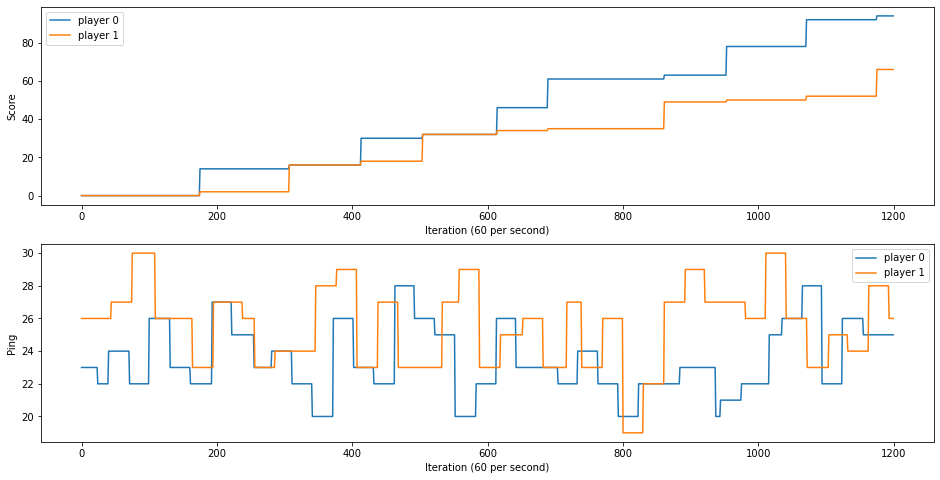

In [9]:
def plot_ping_and_score(game_data):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((16,8)))
    ax1.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax1.set_ylabel('Score')
    ax1.plot(game_data['player_0_scores'], label='player 0')
    ax1.plot(game_data['player_1_scores'], label='player 1')
    ax1.legend()
    ax2.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax2.set_ylabel('Ping')
    ax2.plot(game_data['player_0_pings'], label='player 0')
    ax2.plot(game_data['player_1_pings'], label='player 1')
    ax2.legend()
    
plot_ping_and_score(game_data)

In [10]:
def vec_ncc(arg_a, arg_b, shift=0):  # a and b should have same length
    a, b = None, None
    if shift >= 0:
        a = arg_a[:len(arg_a)-shift]
        b = arg_b[shift:len(arg_a)]
    else:
        a = arg_a[-1*shift:len(arg_a)]
        b = arg_b[:len(arg_a)+shift]
    a_mean, b_mean = a.mean(0), b.mean(0)
    return sum([(a[i]-a_mean).dot(b[i]-b_mean) for i in range(len(a))])/len(a)/(a.std(0).dot(b.std(0)))
    
def vec_ncc_for_shifts(a, b, shift_dist=10):
    return [vec_ncc(a,b,s) for s in range(-shift_dist,shift_dist+1)]

def best_ncc_shift(a, b, search_dist):
    shifts=list(range(-search_dist,search_dist+1))
    pointer_correlation = vec_ncc_for_shifts(a, b, shift_dist=search_dist)
    max_cor_shift = np.argmax(pointer_correlation) - search_dist
    return max_cor_shift, shifts, pointer_correlation

In [11]:
def frames_to_seconds(frames):
    return [f/conf.pos_updates_ps for f in frames]

def plot_cross_correlation(game_data, label):
    p0_pos = game_data['player_0_positions']
    p1_pos = game_data['player_1_positions']
    max_cor_shift, shifts, pointer_correlation_follows = best_ncc_shift(p0_pos, p1_pos, 3 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label=label)
    #print(max_cor_shift)

def plot_cross_correltaion_for_folder(folder, title):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    for i in range(len(file_names)):
        plot_cross_correlation(file_to_data_dict(table_files[i]), file_names[i])
    ax = plt.gca()
    ax.set_xlabel('Shifts in Seconds')
    ax.set_ylabel('Normalized Cross Correlation')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.title(title)
    plt.axvline(0, c='k')
    plt.axhline(0, c='k')
    plt.show()

In [28]:
def vec_auto_correlation_for_shifts(a, shifts):
    return [vec_ncc(a,a,s) for s in shifts]

def best_auto_correlation_shift(a, search_dist):
    shifts=list(range(search_dist+1))
    #pointer_correlation = vec_ncc_for_shifts(a, a, shift_dist=search_dist)
    pointer_correlation = vec_auto_correlation_for_shifts(a, shifts)
    max_cor_shift = np.argmax(pointer_correlation) - search_dist
    return max_cor_shift, shifts, pointer_correlation

def plot_auto_correlation(game_data, label):
    p0_pos = game_data['player_0_positions']
    p1_pos = game_data['player_1_positions']
    max_cor_shift, shifts, pointer_correlation_follows = best_auto_correlation_shift(p0_pos, 6 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label='player_0_positions_' + label)
    max_cor_shift, shifts, pointer_correlation_follows = best_auto_correlation_shift(p1_pos, 6 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label='player_1_positions_' + label)

def plot_auto_correltaion_for_folder(folder, title):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    for i in range(len(file_names)):
        plot_auto_correlation(file_to_data_dict(table_files[i]), file_names[i])
    ax = plt.gca()
    ax.set_xlabel('Shifts in Seconds')
    ax.set_ylabel('Normalized Auto Correlation')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.title(title)
    plt.axvline(0, c='k')
    plt.axhline(0, c='k')
    plt.show()
    


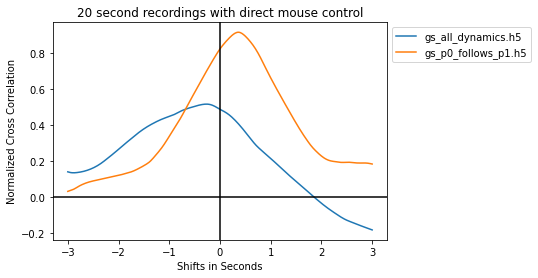

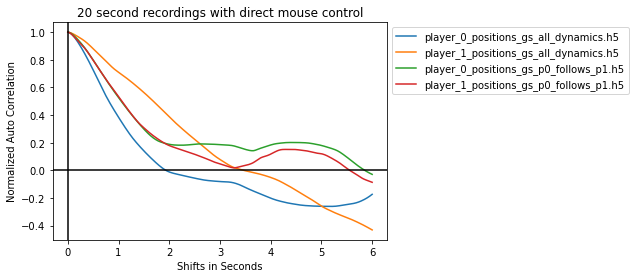

In [29]:
plot_cross_correltaion_for_folder(folder='records_0',
                                  title='20 second recordings with direct mouse control')
plot_auto_correltaion_for_folder(folder='records_0',
                                  title='20 second recordings with direct mouse control')

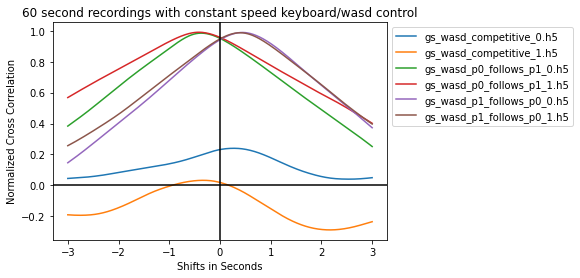

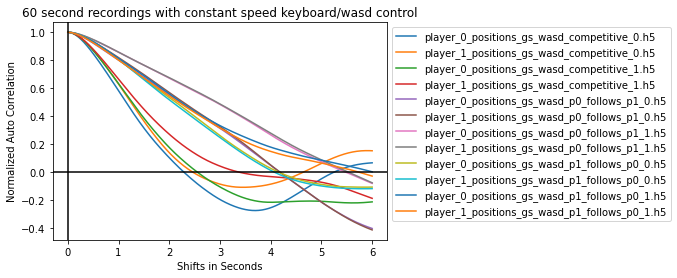

In [30]:
plot_cross_correltaion_for_folder(folder='records_1',
                                  title='60 second recordings with constant speed keyboard/wasd control')
plot_auto_correltaion_for_folder(folder='records_1',
                                  title='60 second recordings with constant speed keyboard/wasd control')

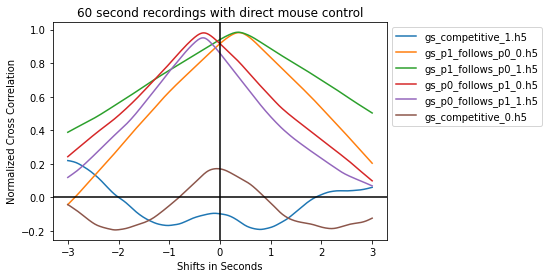

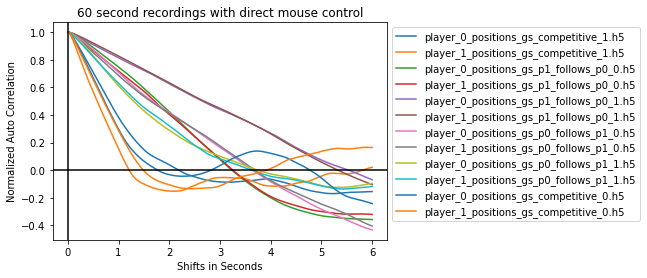

In [31]:
plot_cross_correltaion_for_folder(folder='records_2',
                                  title='60 second recordings with direct mouse control')
plot_auto_correltaion_for_folder(folder='records_2',
                                  title='60 second recordings with direct mouse control')

In [441]:
def scored(i, score_states):
    return np.isnan(score_states[i-1]) and not np.isnan(score_states[i])

def get_scorings(game_record):
    p0_ss=game_record['player_0_score_state']
    p1_ss=game_record['player_1_score_state']
    p0_ts=game_record['player_0_target_states']
    p1_ts=game_record['player_1_target_states']
    comp_p0, comp_p1, coop_p0, coop_p1 = [], [], [], []
    for i in range(1,len(p0_ss)):
        if scored(i,p0_ss) and scored(i,p1_ss) and int(p0_ts[i]) == int(p1_ts[i]):
            if p0_ss[i] > p1_ss[i]:
                coop_p0.append(i)
            else:
                coop_p1.append(i)
        else:
            if scored(i,p0_ss):
                comp_p0.append(i)
            if scored(i,p1_ss):
                comp_p1.append(i)
    return comp_p0, comp_p1, coop_p0, coop_p1

def avg_frames_between_coop_dots(game_record):
    comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(game_record)
    comp = sorted(comp_p0 + comp_p1, reverse=True)
    coop = sorted(coop_p0 + coop_p1, reverse=True)
    last_coop = -1
    frame_diffs = []
    while comp and coop:  # Both of them are not empty
        if coop[-1] < comp[-1]:
            if last_coop != -1:
                frame_diffs.append(coop[-1]-last_coop)
            last_coop = coop.pop()
        else:
            last_coop = -1
            comp.pop()
    last_coop = -1
    while coop:  # Contine if only cooperative occupations left
        if last_coop != -1:
            frame_diffs.append(coop[-1]-last_coop)
        last_coop = coop.pop()
    return sum(frame_diffs)/len(frame_diffs)


In [449]:
window = 120
window = 95
window = int(avg_frames_between_coop_dots(game_data_all_dynamics))

p0_pos = game_data_all_dynamics['player_0_positions']
p1_pos = game_data_all_dynamics['player_1_positions']

cross_correlation_0, cross_correlation_1 = [], []
for i in range(window, 1200):
    cross_correlation_0.append(vec_ncc(p0_pos[i-window:i], p1_pos[i-window:i], shift=best_shift_1))
    cross_correlation_1.append(vec_ncc(p0_pos[i-window:i], p1_pos[i-window:i], shift=-1*best_shift_1))

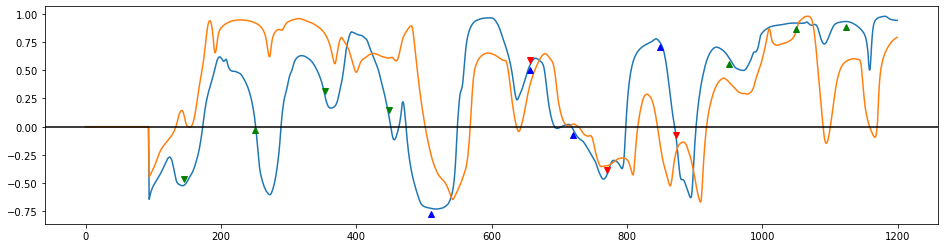

In [450]:
plt.figure(figsize=((16,4)))
plt.plot(np.array(range(window+len(cross_correlation_0))), [0]*window + cross_correlation_0)
plt.plot(np.array(range(window+len(cross_correlation_1))), [0]*window + cross_correlation_1)

def plot_event_on_curve(x_positions, curve, y_offset, fmt):
    plt.plot(x_positions, [curve[x]+y_offset for x in x_positions], fmt)

comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(game_data_all_dynamics)
plot_event_on_curve(x_positions=comp_p0, curve=[0]*window+cross_correlation_0, y_offset=.05,fmt='rv')
plot_event_on_curve(x_positions=comp_p1, curve=[0]*window+cross_correlation_0, y_offset=-.05,fmt='b^')
plot_event_on_curve(x_positions=coop_p0, curve=[0]*window+cross_correlation_0, y_offset=.05,fmt='gv')
plot_event_on_curve(x_positions=coop_p1, curve=[0]*window+cross_correlation_0, y_offset=-.05,fmt='g^')
plt.axhline(0, c='k')
plt.show()

In [ ]:
# Use best shift to classify cooperation/competition...

In [377]:
window = 180

p0_pos = game_data_all_dynamics['player_0_positions']
p1_pos = game_data_all_dynamics['player_1_positions']

best_shifts = []
from tqdm import tqdm
for i in tqdm(range(window, 1200)):
    windows_best_shift, _, _, = best_ncc_shift(p0_pos[i-window:i], p1_pos[i-window:i], search_dist=2*60)
    best_shifts.append(windows_best_shift)

100%|██████████| 1020/1020 [01:22<00:00, 12.39it/s]


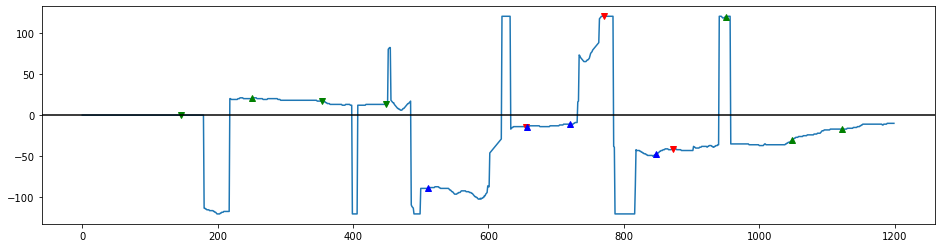

In [378]:
plt.figure(figsize=((16,4)))
plt.plot(np.array(range(window+len(best_shifts))), [0]*window+best_shifts)
plot_event_on_curve(x_positions=comp_p0, curve=[0]*window+best_shifts, y_offset=.05,fmt='rv')
plot_event_on_curve(x_positions=comp_p1, curve=[0]*window+best_shifts, y_offset=-.05,fmt='b^')
plot_event_on_curve(x_positions=coop_p0, curve=[0]*window+best_shifts, y_offset=.05,fmt='gv')
plot_event_on_curve(x_positions=coop_p1, curve=[0]*window+best_shifts, y_offset=-.05,fmt='g^')
plt.axhline(0, c='k')
plt.show()